<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/Final_Sentiment_Analisis_Produk_Dengan_Algoritma_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from wordcloud import WordCloud
import joblib

Mengunduh resource nltk yang diperlukan

In [17]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Muat dataset

In [26]:
df = pd.read_csv('datalatih_ulasanprodukshopee_final.csv', encoding='MacRoman')
df.head(10)

,no,username,tanggal,content,texture,effectiveness,absorption capacity,score,sentiment
0,1,z*****e,2024-10-10,Pertama kali coba karena baca ulasan di Quora ...,cream gel,baru pertama x coba Guys mudah2an manjur,pas,4,Positif
1,2,dindardew,2024-03-09,Penasaran bgt dari dulu udah laser jg bekas lu...,lembut dan dingin ke kulit,belum tau baru d pakai sehari,cepet,5,Positif
2,3,dikamungil,2024-03-09,"Udah ku pke beberapa kali sih, semoga bermanfa...",gel,baik,cepat,5,Positif
3,4,cakranouval,2024-11-08,Mudahan cocok,gel lembut,efektif,cepat,5,Positif
4,5,ilhamansyari22,2024-06-18,Barang sesuai pesanan ‚àö¬¢√Ä√∫¬¨‚à´‚àö√ò¬¨‚àè...,gel lembut,efektif,cepat,5,Netral
5,6,inggihsatrianisatriani,2024-06-18,Baru pertama kali coba mudah mudahan bisa puda...,baik,blom tau baru coba,bagus,5,Positif
6,7,m*****4,2024-06-06,"Baru mau nyoba, semoga manjur menghilangkan be...",gel,bagus,bagus,5,Positif
7,8,nonaa2,2024-02-06,"Cottonbud gak dikasih, pelit banget, gimana pa...",gel,bagus,baik,3,Negatif
8,9,linarifqun,2024-12-05,Alhamdulillah Paketku sudah sampai pesanannya ...,gel,bagus,bagus,3,Positif
9,10,v*****8,2024-11-05,"Dikasih thr sama kakaknya, MasyaAllah berkah s...",gel kental,semoga bekerja dengan baik,belum tau,5,Positif


Melakukan data selection

In [72]:
# Memilih kolom yang relevan
df_selected = df[['username', 'content', 'sentiment']]

# Menghapus baris yang memiliki nilai kosong pada kolom yang dipilih
df_selected.dropna(inplace=True)

# Menampilkan 10 baris pertama dari data yang telah diseleksi
df_selected.head(10)

<ipython-input-72-4f620dc7d6a2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(inplace=True)


,username,content,sentiment
0,z*****e,"Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas h...",positive
1,dindardew,Penasaran bgt dari dulu udah laser jg bekas luka gak ilang Nemu produk ini jadi coba aja dulu si...,positive
2,dikamungil,"Udah ku pke beberapa kali sih, semoga bermanfaat. Makasih ya seller. Harganya mahal tp semoga am...",positive
3,cakranouval,Mudahan cocok,positive
4,ilhamansyari22,Barang sesuai pesanan ‚àö¬¢√Ä√∫¬¨‚à´‚àö√ò¬¨‚àè¬¨√®,neutral
5,inggihsatrianisatriani,Baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya Maksih semoga berkah Kalau coco...,positive
6,m*****4,"Baru mau nyoba, semoga manjur menghilangkan bekas luka , keloid, pengiriman cepat, terima kasih",positive
7,nonaa2,"Cottonbud gak dikasih, pelit banget, gimana pake nya ini, gak jelas sumpah, udah 2 kali saya gak...",negative
8,linarifqun,Alhamdulillah Paketku sudah sampai pesanannya sesuai bahannya Adem Lumayan suka dengan harga seg...,positive
9,v*****8,"Dikasih thr sama kakaknya, MasyaAllah berkah selalu kak",neutral


Daftar stopwords dari NLTK dan tambahan khusus Bahasa Indonesia

In [27]:
stopwords_tambahan = list([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin'
])

Inisialisasi Lemmatizer

In [28]:
lemmatizer = WordNetLemmatizer()

Fungsi untuk membersihkan teks

In [29]:
def bersihkan_teks(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = re.sub(r'\d+', '', teks)
    kata_kata = teks.split()
    teks_bersih = ' '.join([lemmatizer.lemmatize(kata) for kata in kata_kata if kata not in stopwords_tambahan])
    return teks_bersih

Terapkan fungsi pembersihan pada kolom 'content'

In [30]:
df['cleaned_content'] = df['content'].apply(bersihkan_teks)

Tampilkan sebagian kecil dari teks yang sudah dibersihkan untuk memastikan hasilnya

In [39]:
# Ambil 10 baris pertama untuk perbandingan antara teks asli dan teks yang sudah dibersihkan
df_comparison = df[['content', 'cleaned_content']].head(10)

# Atur lebar tampilan kolom dan potong teks yang terlalu panjang
pd.set_option('display.max_colwidth', 100)  # Set kolom maksimum lebar per baris
pd.set_option('display.width', 200)         # Set total lebar tampilan tabel

# Tampilkan tabel perbandingan
print("Perbandingan Teks Sebelum dan Sesudah Pembersihan:\n")
print(df_comparison)

Perbandingan Teks Sebelum dan Sesudah Pembersihan:

                                                                                               content  \
0  Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas h...   
1  Penasaran bgt dari dulu udah laser jg bekas luka gak ilang Nemu produk ini jadi coba aja dulu si...   
2  Udah ku pke beberapa kali sih, semoga bermanfaat. Makasih ya seller. Harganya mahal tp semoga am...   
3                                                                                        Mudahan cocok   
4                                                   Barang sesuai pesanan ‚àö¬¢√Ä√∫¬¨‚à´‚àö√ò¬¨‚àè¬¨√®   
5  Baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya Maksih semoga berkah Kalau coco...   
6      Baru mau nyoba, semoga manjur menghilangkan bekas luka , keloid, pengiriman cepat, terima kasih   
7  Cottonbud gak dikasih, pelit banget, gimana pake nya ini, gak jelas sumpah, udah 2 kali saya gak.

Kamus subjektivitas dengan kategori intensitas dan polaritas emosional

In [40]:
# Definisikan daftar kata-kata positif dan negatif berdasarkan kamus subjektivitas yang merujuk pada buku 'pengantar metode analisis sentimen'
positif = [
    'pembebasan', 'penghargaan', 'altruistik', 'luar biasa', 'hebat', 'inspiratif', 'bagus',
    'puas', 'baik', 'suka', 'keren', 'bagus sekali', 'cepat', 'efektif', 'cocok', 'manjur',
    'ampuh', 'berhasil', 'kepuasan', 'kekaguman', 'gembira', 'menerima', 'berlimpah', 'makmur',
    'aliansi', 'kondusif', 'sederhana', 'semoga', 'semoga cocok', 'bahagia', 'senang', 'syukur',
    'bersemangat', 'lega', 'bangga', 'optimis', 'prestasi', 'pencapaian', 'menang', 'berkembang',
    'memperbaiki', 'produktif', 'menghargai', 'mengagumi', 'mendukung', 'percaya', 'mencintai',
    'memuji', 'setia', 'nyaman', 'damai', 'tenteram', 'harmonis', 'berkelimpahan', 'dermawan',
    'empati', 'peduli', 'ramah', 'murah hati', 'kebebasan', 'keterbukaan', 'kesempatan', 'harapan',
    'stabil', 'terjamin', 'tenang', 'penyelesaian', 'penyembuhan', 'pemulihan', 'penanggulangan',
    'solusi', 'peningkatan', 'sukses', 'berhasil', 'penuh kasih', 'inovasi', 'berkat', 'semoga berhasil'
]

negatif = [
    'pelecehan', 'kekejian', 'ketakutan', 'kekhawatiran', 'penindasan', 'frustrasi', 'buruk',
    'tidak puas', 'jelek', 'kecewa', 'payah', 'lambat', 'rusak', 'kotor', 'gagal', 'mengecewakan',
    'mahal', 'pecah', 'cuek', 'jutek', 'penyok', 'sampah', 'pelit', 'kurang', 'tidak bermanfaat',
    'bingung', 'parah', 'kurang cocok', 'expired', 'hancur', 'menghapuskan', 'kecanduan',
    'terasing', 'terbatas', 'kekurangan', 'tersendat', 'marah', 'jengkel', 'sedih', 'benci',
    'gelisah', 'stres', 'putus asa', 'gusar', 'penghinaan', 'kekerasan', 'penghinaan', 'bullying',
    'konflik', 'kerugian', 'kebangkrutan', 'kekalahan', 'kerusakan', 'tidak berhasil', 'melemah',
    'terganggu', 'penyalahgunaan', 'terjangkit', 'kritis', 'cacat', 'krisis', 'kemiskinan',
    'pengangguran', 'kesulitan', 'kesusahan', 'hambatan', 'ketidakpercayaan', 'isolasi',
    'permusuhan', 'egois', 'mencemarkan', 'mempersulit', 'membatasi', 'mengurangi', 'mengancam',
    'terpaksa', 'terkekang', 'tertindas', 'terancam', 'tidak berkembang'
]


Fungsi untuk menetapkan sentimen berdasarkan kamus subjektivitas yang digabungkan

In [41]:
def aturan_sentimen(teks):
    teks = teks.lower()
    if any(kata in teks for kata in positif):
        return 'positive'
    elif any(kata in teks for kata in negatif):
        return 'negative'
    else:
        return 'neutral'

Terapkan aturan sentimen

In [42]:
df['sentiment'] = df['cleaned_content'].apply(aturan_sentimen)

Pisahkan data menjadi berlabel dan tak berlabel

In [43]:
df_labeled = df[df['sentiment'].notna()]  # Data berlabel manual (200 data)
df_unlabeled = df[df['sentiment'].isna()]  # Data tanpa label (975 data)

Vektorisasi menggunakan TF-IDF dengan unigram, bigram, dan trigram

In [44]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.75,
    min_df=3,
    stop_words=stopwords_tambahan,
    max_features=5000
)
X_labeled = vectorizer.fit_transform(df_labeled['cleaned_content'])
y_labeled = df_labeled['sentiment']

In [48]:
# Ambil 10 sampel komentar acak dari kolom 'content' untuk analisis TF-IDF
sample_content = df['content'].sample(10, random_state=1).tolist()

# Terapkan vektorisasi TF-IDF pada sampel komentar yang telah diambil
vectorizer = TfidfVectorizer()
X_sample = vectorizer.fit_transform(sample_content)

# Ubah hasil TF-IDF menjadi DataFrame agar lebih mudah dibaca
feature_names = vectorizer.get_feature_names_out()
tfidf_sample_df = pd.DataFrame(X_sample.toarray(), columns=feature_names)

# Tampilkan nilai TF-IDF untuk sampel komentar yang diambil
tfidf_sample_df.head()

,2x,3x,ada,aja,alhamdulillah,amanah,ampuh,anti,awalnya,banget,...,untuk,ya,yang,yg,you,àè,àö,àû,âà,äö
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.159452,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.159903,0.000000,0.000000,0.000000,...,0.188101,0.0,0.000000,0.279792,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.150801,0.150801,0.150801,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.512778,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.125354,0.000000,0.147459,0.125354,...,0.000000,0.0,0.125354,0.000000,0.0,0.350257,0.350257,0.390017,0.390017,0.000000
4,0.0,0.000000,0.000000,0.000000,0.0,0.194221,0.000000,0.194221,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.230665,0.230665,0.256849,0.256849,0.144448


Pisahkan data menjadi data latih dan data uji

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled)

# **Model : Naive Bayes**

---



Hyperparameter Tuning untuk Model Naive Bayes

In [50]:
param_grid_nb = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='f1_macro')
grid_search_nb.fit(X_train, y_train)
best_nb_model = grid_search_nb.best_estimator_

Simpan Parameter Terbaik dari Grid Search

In [51]:
print("Best Hyperparameters (alpha):", grid_search_nb.best_params_)

Best Hyperparameters (alpha): {'alpha': 0.01}


Cross-Validation untuk Mengecek Stabilitas Model

In [52]:
cv_scores = cross_val_score(best_nb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Akurasi Rata-rata Cross-Validation:", cv_scores.mean())

Akurasi Rata-rata Cross-Validation: 0.7551810790835182


Evaluasi Model

In [53]:
y_pred = best_nb_model.predict(X_test)
print("=== Laporan Klasifikasi ===")
print(classification_report(y_test, y_pred))
print("Akurasi:", accuracy_score(y_test, y_pred))

=== Laporan Klasifikasi ===
              precision    recall  f1-score   support

    negative       0.87      0.71      0.78        28
     neutral       0.64      0.33      0.43        89
    positive       0.77      0.93      0.84       236

    accuracy                           0.76       353
   macro avg       0.76      0.66      0.69       353
weighted avg       0.75      0.76      0.74       353

Akurasi: 0.7620396600566572


Confusion Matrix

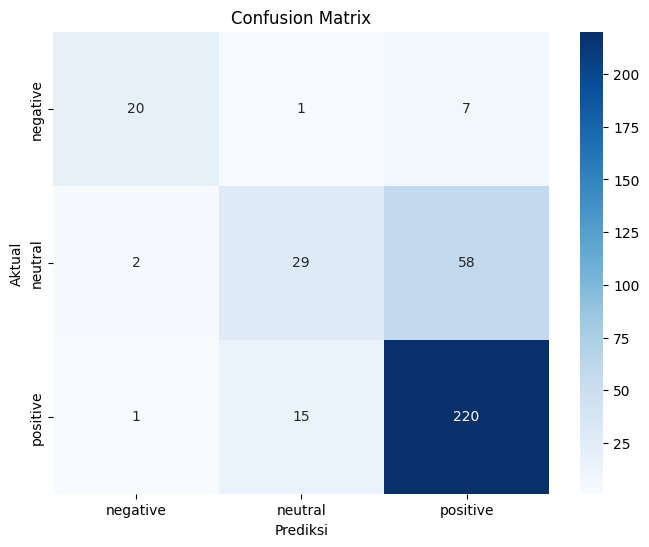

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_nb_model.classes_, yticklabels=best_nb_model.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

Precision, Recall, dan F1-Score untuk setiap Kelas

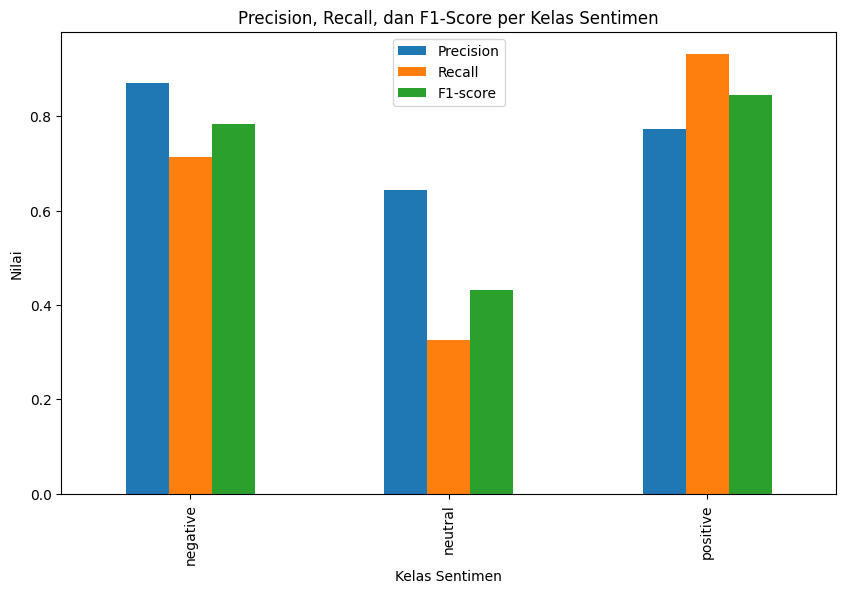

In [55]:
metrics = precision_recall_fscore_support(y_test, y_pred, average=None, labels=best_nb_model.classes_)
metric_df = pd.DataFrame({
    'Kelas Sentimen': best_nb_model.classes_,
    'Precision': metrics[0],
    'Recall': metrics[1],
    'F1-score': metrics[2]
})
metric_df.set_index('Kelas Sentimen').plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, dan F1-Score per Kelas Sentimen")
plt.ylabel("Nilai")
plt.xlabel("Kelas Sentimen")
plt.show()

Distribusi Sentimen Bar Chart

<ipython-input-60-2515b2a5752b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])


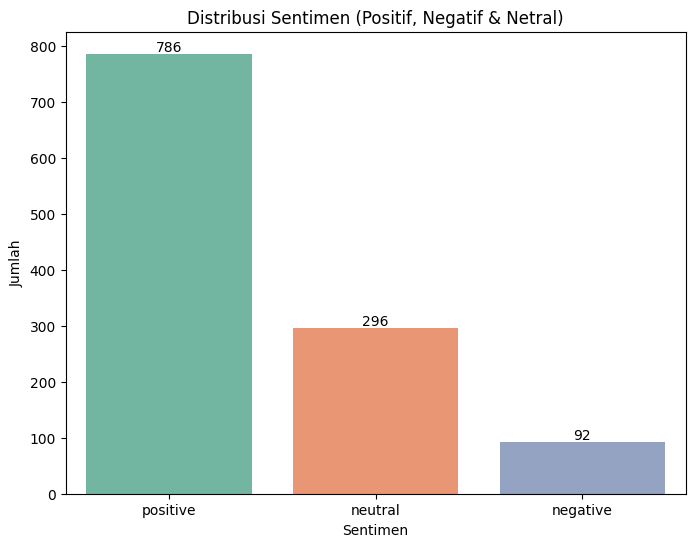

In [60]:
# Buat plot batang dengan warna yang sama seperti pada pie chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])

# Tambahkan label pada setiap bar
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 5, str(value), ha='center')  # 5 units above the bar for clarity

# Atur label dan judul
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen (Positif, Negatif & Netral)')
plt.show()


Distribusi Sentimen Pie Chart

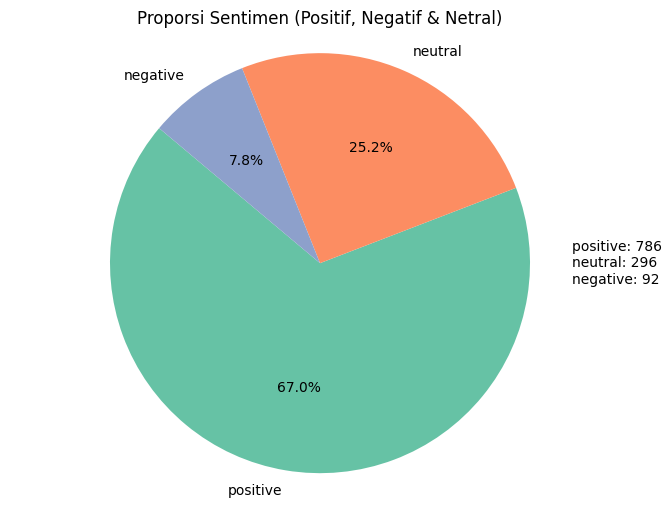

In [59]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
total_text = "\n".join([f"{label}: {count}" for label, count in zip(sentiment_counts.index, sentiment_counts.values)])
plt.text(1.2, 0, total_text, ha='left', va='center', fontsize=10, color='black')
plt.axis('equal')  # Agar pie chart menjadi bulat
plt.title('Proporsi Sentimen (Positif, Negatif & Netral)')
plt.show()

Wordcloud untuk ulasan positif

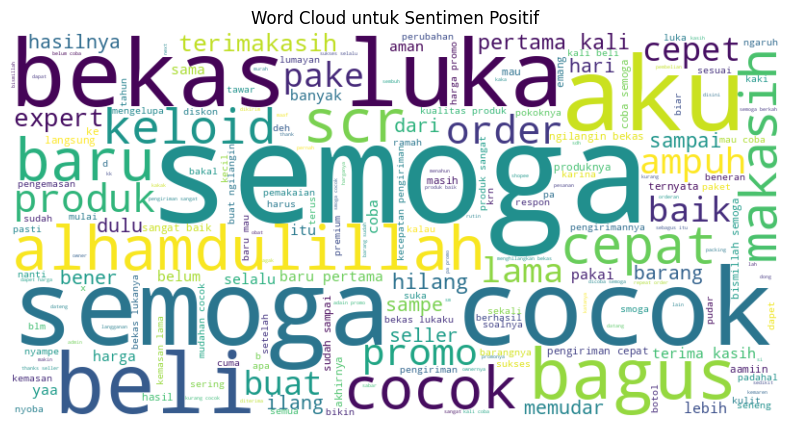

In [61]:
positif_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_content'])
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(positif_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif')
plt.show()

Wordcloud untuk ulasan Negatif

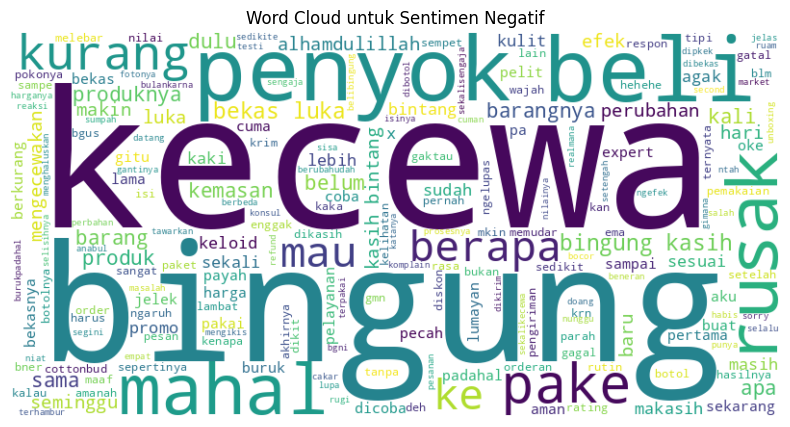

In [62]:
negatif_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_content'])
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif')
plt.show()

Wordcloud untuk ulasan netral

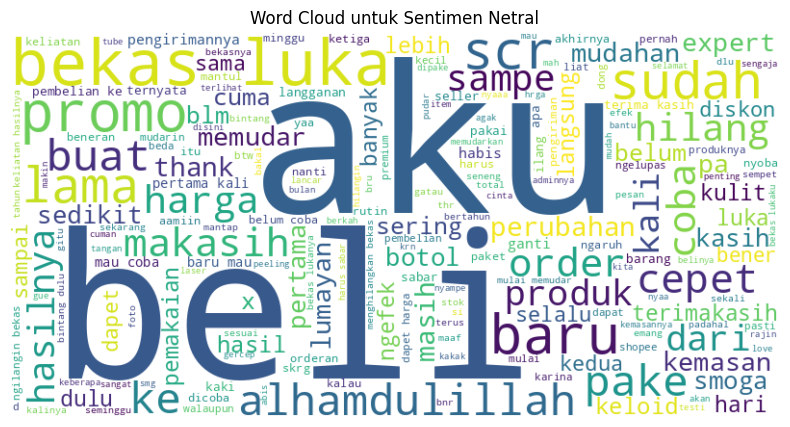

In [63]:
netral_text = ' '.join(df[df['sentiment'] == 'neutral']['cleaned_content'])
wordcloud_netral = WordCloud(width=800, height=400, background_color='white').generate(netral_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_netral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Netral')
plt.show()

Bar Plot Kata-Kata yang Paling Sering Muncul

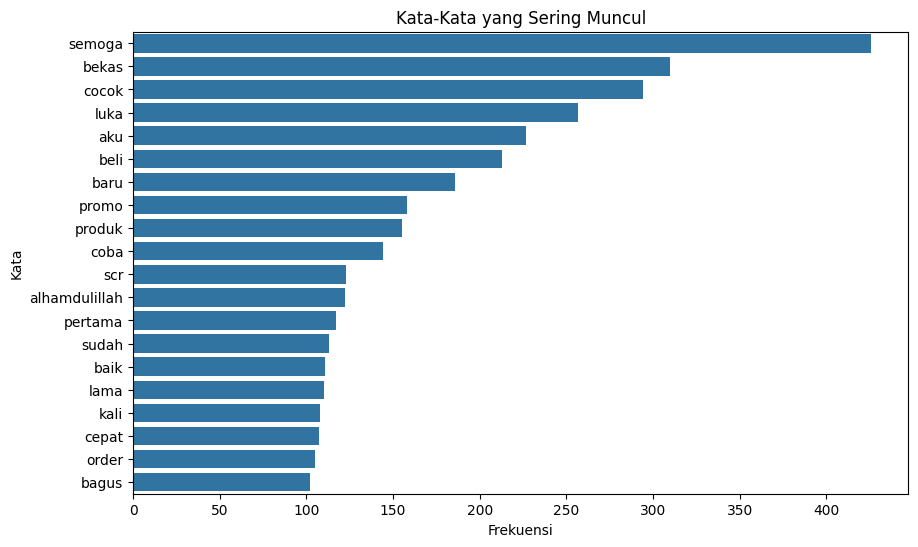

In [64]:
count_vectorizer = CountVectorizer(max_features=20)
word_counts = count_vectorizer.fit_transform(df['cleaned_content'])
word_counts_sum = word_counts.sum(axis=0)
words_freq = [(word, word_counts_sum[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq_df = pd.DataFrame(words_freq, columns=['Kata', 'Frekuensi'])

plt.figure(figsize=(10, 6))
sns.barplot(data=words_freq_df, x='Frekuensi', y='Kata')
plt.title("Kata-Kata yang Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

Simpan model dan vectorizer untuk digunakan pada data baru

In [66]:
joblib.dump(best_nb_model, 'model_naive_bayes.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

Filter data yang belum diberi label (jika ada)

In [67]:
df_unlabeled = df[df['sentiment'].isna()]

Periksa apakah ada data tanpa label sebelum melakukan transformasi dan prediksi

In [68]:
if not df_unlabeled.empty:
    X_unlabeled = vectorizer.transform(df_unlabeled['cleaned_content'])
    df_unlabeled['predicted_sentiment'] = best_nb_model.predict(X_unlabeled)
    # Gabungkan data berlabel dan data yang diprediksi
    df_final = pd.concat([df, df_unlabeled], ignore_index=True)
else:
    print("Tidak ada data tanpa label yang perlu diprediksi.")
    df_final = df  # Jika tidak ada data tanpa label, langsung gunakan data asli

Tidak ada data tanpa label yang perlu diprediksi.


Simpan hasil prediksi ke file CSV

In [70]:
df_final.to_csv('final_hasil_prediksi_sentimen_naivebayes.csv', index=False)
print("Hasil prediksi sentimen telah disimpan dalam file 'final_hasil_prediksi_sentimen_naivebayes.csv'.")

Hasil prediksi sentimen telah disimpan dalam file 'final_hasil_prediksi_sentimen_naivebayes.csv'.
